In [3]:
import sys
import os
from pathlib import Path
import pandas as pd
import datetime as dt
from mlrun.platforms import auto_mount


DATA_DIR = "data"
MLRUN_ENV_FILE = "mlrun.env"

import mlrun

mlrun.set_env_from_file(MLRUN_ENV_FILE)

project = mlrun.get_or_create_project(
    "predictive-maintenance",
    parameters={
        "source": "s3://mlrun/predictive-maintenance.zip",
        "default_image": "felipenv/mlrun-predictive:1.9",
    },
)

project.set_secrets(
    secrets={
        "AWS_ACCESS_KEY_ID": "minio",
        "AWS_SECRET_ACCESS_KEY": "minio123",
        "S3_ENDPOINT_URL": "http://minio:9000",
        "S3_USE_HTTPS": "False",
        "S3_VERIFY_SSL": "False",
        "AWS_DEFAULT_REGION": "us-east-1",
        "S3_NON_ANONYMOUS": "True",
        "S3_USE_PATH_STYLE": "True"
    }
)

project.set_secrets(
    secrets={
        "PG_HOST": "optimus-postgres.mlrun.svc.cluster.local",
        "PG_USER": "optimus",
        "PG_PASSWORD": "optimus",
        "PG_DB": "optimus",
    }
)



Project Source: s3://mlrun/predictive-maintenance.zip
Exporting project as zip archive to s3://mlrun/predictive-maintenance.zip...
> 2025-09-02 16:11:17,753 [info] Project loaded successfully: {"project_name":"predictive-maintenance"}


> 2025-09-02 15:41:20,313 [info] Submitting remote workflow: {"project_name":"predictive-maintenance","schedule":null,"workflow_engine":"kfp"}


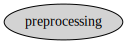

> 2025-09-02 15:41:32,289 [info] Started run workflow predictive-maintenance-training-workflow with run id = '4816c49c-59e7-4aab-bf90-16fb7b0891a6' by remote engine
> 2025-09-02 15:41:32,304 [info] Waiting for pipeline run completion: {"project":"predictive-maintenance","run_id":"4816c49c-59e7-4aab-bf90-16fb7b0891a6"}


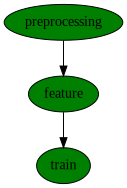

uid,start,end,state,kind,name,parameters,results
...6318d8d8,Sep 02 15:43:27,2025-09-02 15:43:37.246582+00:00,completed,run,train,,return=trained_nbeatsx_model
...f2431629,Sep 02 15:42:42,2025-09-02 15:42:44.705537+00:00,completed,run,feature,,
...53394f18,Sep 02 15:41:56,2025-09-02 15:42:00.043726+00:00,completed,run,preprocessing,,


In [2]:
training_run_id = project.run(
    name="training-workflow",
    arguments={
        "Y_train_df": project.get_artifact(key="Y_train_df").uri,
        "Y_test_df": project.get_artifact(key="Y_test_df").uri,
    },
    engine="remote",
    watch=True,
    dirty=True,
)

> 2025-09-02 16:11:18,915 [info] Submitting remote workflow: {"project_name":"predictive-maintenance","schedule":null,"workflow_engine":"kfp"}


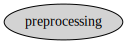

> 2025-09-02 16:11:32,653 [info] Started run workflow predictive-maintenance-inference-workflow with run id = 'a820b685-539f-4302-96b4-5627ba969094' by remote engine
> 2025-09-02 16:11:32,660 [info] Waiting for pipeline run completion: {"project":"predictive-maintenance","run_id":"a820b685-539f-4302-96b4-5627ba969094"}


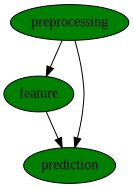

uid,start,end,state,kind,name,parameters,results
...a5548942,Sep 02 16:13:26,2025-09-02 16:13:37.796639+00:00,completed,run,prediction,,
...fe3c1d5c,Sep 02 16:12:43,2025-09-02 16:12:45.915886+00:00,completed,run,feature,,
...52b762a1,Sep 02 16:11:54,2025-09-02 16:11:57.761917+00:00,completed,run,preprocessing,,


In [4]:
inference_run_id = project.run(
    name="inference-workflow",
    arguments={
        "Y_train_df": project.get_artifact(key="Y_train_df").uri,
        "Y_test_df": project.get_artifact(key="Y_test_df").uri,
        "model": project.get_artifact(key="nbeatsx_model").uri,
    },
    engine="remote",
    watch=True,
    dirty=True,
)